# HumanEval Performance Analysis

This notebook analyzes the performance results from running HumanEval problems with and without monitoring.


In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Load the results
results_file = Path('humaneval_performance_results.json')
if not results_file.exists():
    print("Results file not found. Make sure to run run.py first!")
else:
    with open(results_file, 'r') as f:
        results = json.load(f)
    print(f"Loaded {len(results)} results")


Loaded 164 results


In [2]:
# Process the results into a DataFrame
processed_data = []

for result in results:
    if 'error' in result:
        continue
    
    problem_idx = result['problem_index']
    
    # Reference data
    if 'reference' in result and 'error' not in result['reference']:
        ref_data = result['reference']
        processed_data.append({
            'problem_index': problem_idx,
            'version': 'reference',
            'wall_time': ref_data.get('wall_time', 0),
            'user_time': ref_data.get('user_time', 0),
            'problem_time': sum(ref_data.get('internal_time', []))/len(ref_data.get('internal_time', [])) / 1e9 if ref_data.get('internal_time', []) else 0,
            'system_time': ref_data.get('system_time', 0),
            'max_memory_kb': ref_data.get('max_memory_kb', 0),
            'success': ref_data.get('success', False),
            'db_size_bytes': 0  # No database for reference
        })
    
    # Monitored data
    if 'monitored_line' in result and 'error' not in result['monitored_line']:
        mon_data = result['monitored_line']
        processed_data.append({
            'problem_index': problem_idx,
            'version': 'monitored_line',
            'wall_time': mon_data.get('wall_time', 0),
            'user_time': mon_data.get('user_time', 0),
            'system_time': mon_data.get('system_time', 0),
            'problem_time': sum(mon_data.get('internal_time', []))/len(mon_data.get('internal_time', [])) / 1e9 if mon_data.get('internal_time', []) else 0,
            'max_memory_kb': mon_data.get('max_memory_kb', 0),
            'success': mon_data.get('success', False),
            'db_size_bytes': mon_data.get('db_size_bytes', 0)
        })

    if 'monitored_function' in result and 'error' not in result['monitored_function']:
        mon_data = result['monitored_function']
        processed_data.append({
            'problem_index': problem_idx,
            'version': 'monitored_function',
            'wall_time': mon_data.get('wall_time', 0),
            'user_time': mon_data.get('user_time', 0),
            'system_time': mon_data.get('system_time', 0),
            'problem_time': sum(mon_data.get('internal_time', []))/len(mon_data.get('internal_time', [])) / 1e9 if mon_data.get('internal_time', []) else 0,
            'max_memory_kb': mon_data.get('max_memory_kb', 0),
            'success': mon_data.get('success', False),
            'db_size_bytes': mon_data.get('db_size_bytes', 0)
        })

df = pd.DataFrame(processed_data)
print(f"Processed {len(df)} data points")
print(f"Success rate - Reference: {df[df['version'] == 'reference']['success'].mean():.2%}")
print(f"Success rate - Monitored: {df[df['version'] == 'monitored_line']['success'].mean():.2%}")
print(f"Success rate - Monitored Function: {df[df['version'] == 'monitored_function']['success'].mean():.2%}")

# Show basic statistics
df.groupby('version').agg({
    'wall_time': ['mean', 'median', 'std'],
    'max_memory_kb': ['mean', 'median', 'std'],
    'success': 'mean',
    'problem_time': ['mean', 'median', 'std']
}).round(4)


Processed 492 data points
Success rate - Reference: 99.39%
Success rate - Monitored: 81.71%
Success rate - Monitored Function: 99.39%


wall_time                    max_memory_kb         \
                        mean   median       std          mean median   
version                                                                
monitored_function    7.3983   7.2459    4.1672      690.5854    0.0   
monitored_line       83.4809  19.4279  111.8880    12895.4390    0.0   
reference             0.7537   0.3260    2.3988     1946.4878    0.0   

                               success problem_time                  
                           std    mean         mean  median     std  
version                                                              
monitored_function   6709.2715  0.9939       0.0093  0.0078  0.0109  
monitored_line      93690.2416  0.8171       0.0627  0.0152  0.1711  
reference            8131.3579  0.9939       0.0018  0.0000  0.0097

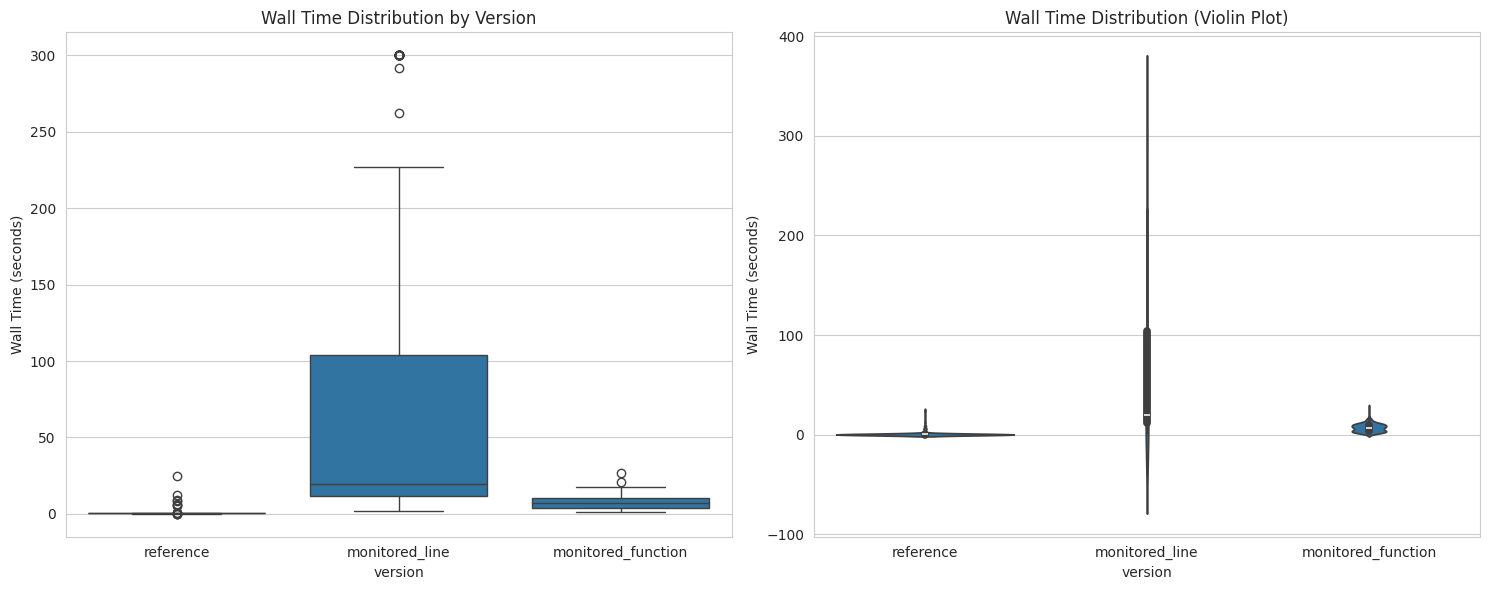

In [3]:
# Plot 1: Wall Time Comparison
plt.figure(figsize=(15, 6))

# Box plot
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='version', y='wall_time')
plt.title('Wall Time Distribution by Version')
plt.ylabel('Wall Time (seconds)')

# Violin plot
plt.subplot(1, 2, 2)
sns.violinplot(data=df, x='version', y='wall_time')
plt.title('Wall Time Distribution (Violin Plot)')
plt.ylabel('Wall Time (seconds)')


plt.tight_layout()
plt.show()


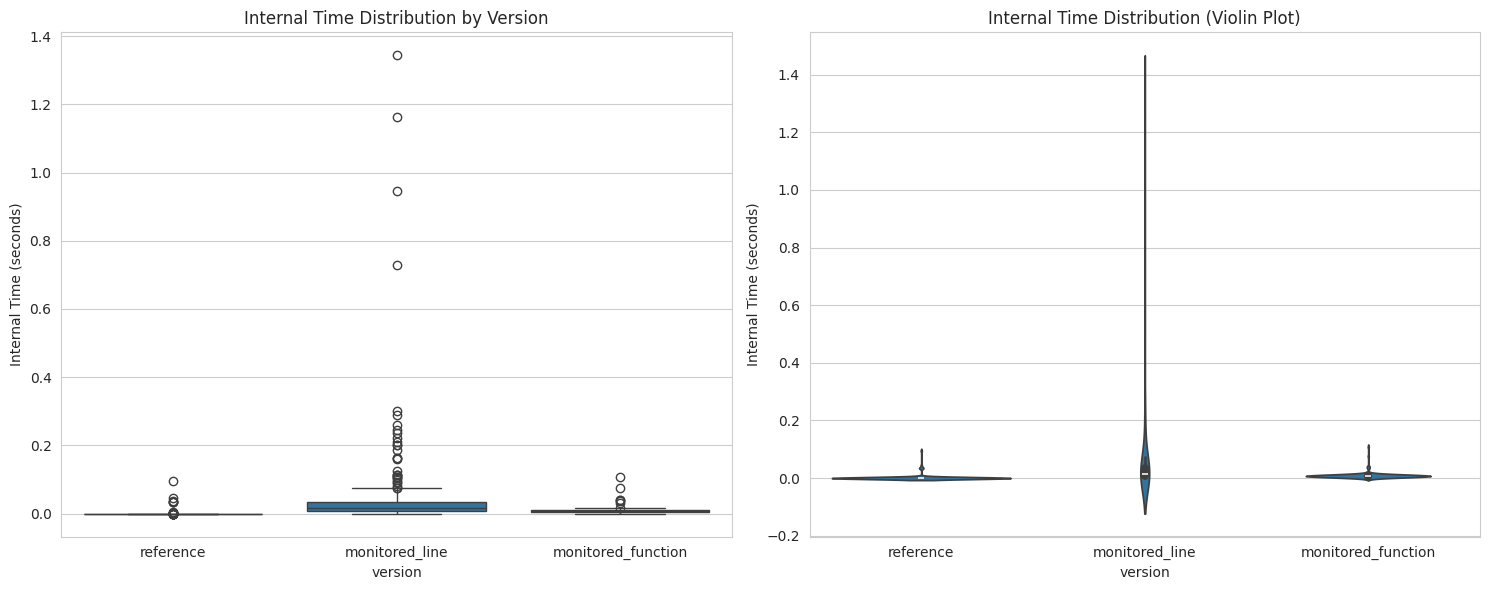

In [4]:
# Intenral time
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='version', y='problem_time')
plt.title('Internal Time Distribution by Version')
plt.ylabel('Internal Time (seconds)')

# Violin plot
plt.subplot(1, 2, 2)
sns.violinplot(data=df, x='version', y='problem_time')
plt.title('Internal Time Distribution (Violin Plot)')
plt.ylabel('Internal Time (seconds)')

plt.tight_layout()
plt.show()

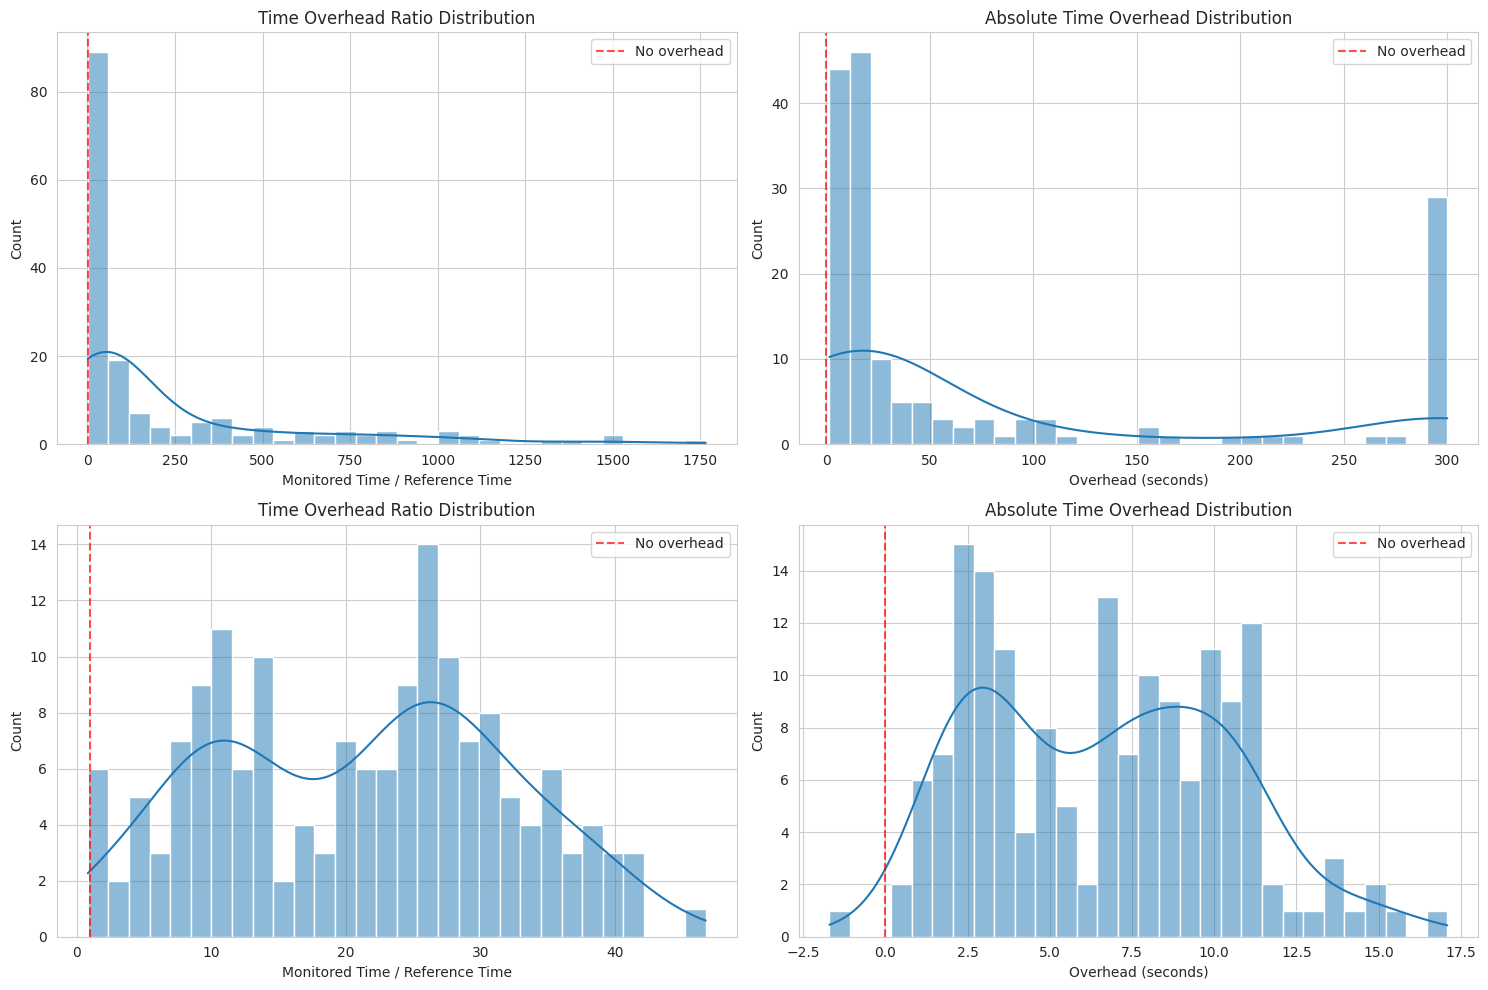

In [5]:
# Plot 3: Performance Overhead Analysis
plt.figure(figsize=(15, 10))

# Calculate overhead for successful runs
pivot_time = df.pivot(index='problem_index', columns='version', values='wall_time')
pivot_time = pivot_time.dropna()
pivot_time['overhead_ratio_line'] = pivot_time['monitored_line'] / pivot_time['reference']
pivot_time['overhead_absolute_line'] = pivot_time['monitored_line'] - pivot_time['reference']
pivot_time['overhead_ratio_function'] = pivot_time['monitored_function'] / pivot_time['reference']
pivot_time['overhead_absolute_function'] = pivot_time['monitored_function'] - pivot_time['reference']

# Overhead ratio distribution
plt.subplot(2, 2, 1)
sns.histplot(pivot_time['overhead_ratio_line'], bins=30, kde=True)
plt.axvline(x=1, color='red', linestyle='--', alpha=0.7, label='No overhead')
plt.title('Time Overhead Ratio Distribution')
plt.xlabel('Monitored Time / Reference Time')
plt.legend()

# Absolute overhead
plt.subplot(2, 2, 2)
sns.histplot(pivot_time['overhead_absolute_line'], bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='No overhead')
plt.title('Absolute Time Overhead Distribution')
plt.xlabel('Overhead (seconds)')
plt.legend()

# Overhead ratio distribution
plt.subplot(2, 2, 3)
sns.histplot(pivot_time['overhead_ratio_function'], bins=30, kde=True)
plt.axvline(x=1, color='red', linestyle='--', alpha=0.7, label='No overhead')
plt.title('Time Overhead Ratio Distribution')
plt.xlabel('Monitored Time / Reference Time')
plt.legend()

# Absolute overhead
plt.subplot(2, 2, 4)
sns.histplot(pivot_time['overhead_absolute_function'], bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='No overhead')
plt.title('Absolute Time Overhead Distribution')
plt.xlabel('Overhead (seconds)')
plt.legend()
plt.tight_layout()
plt.show()


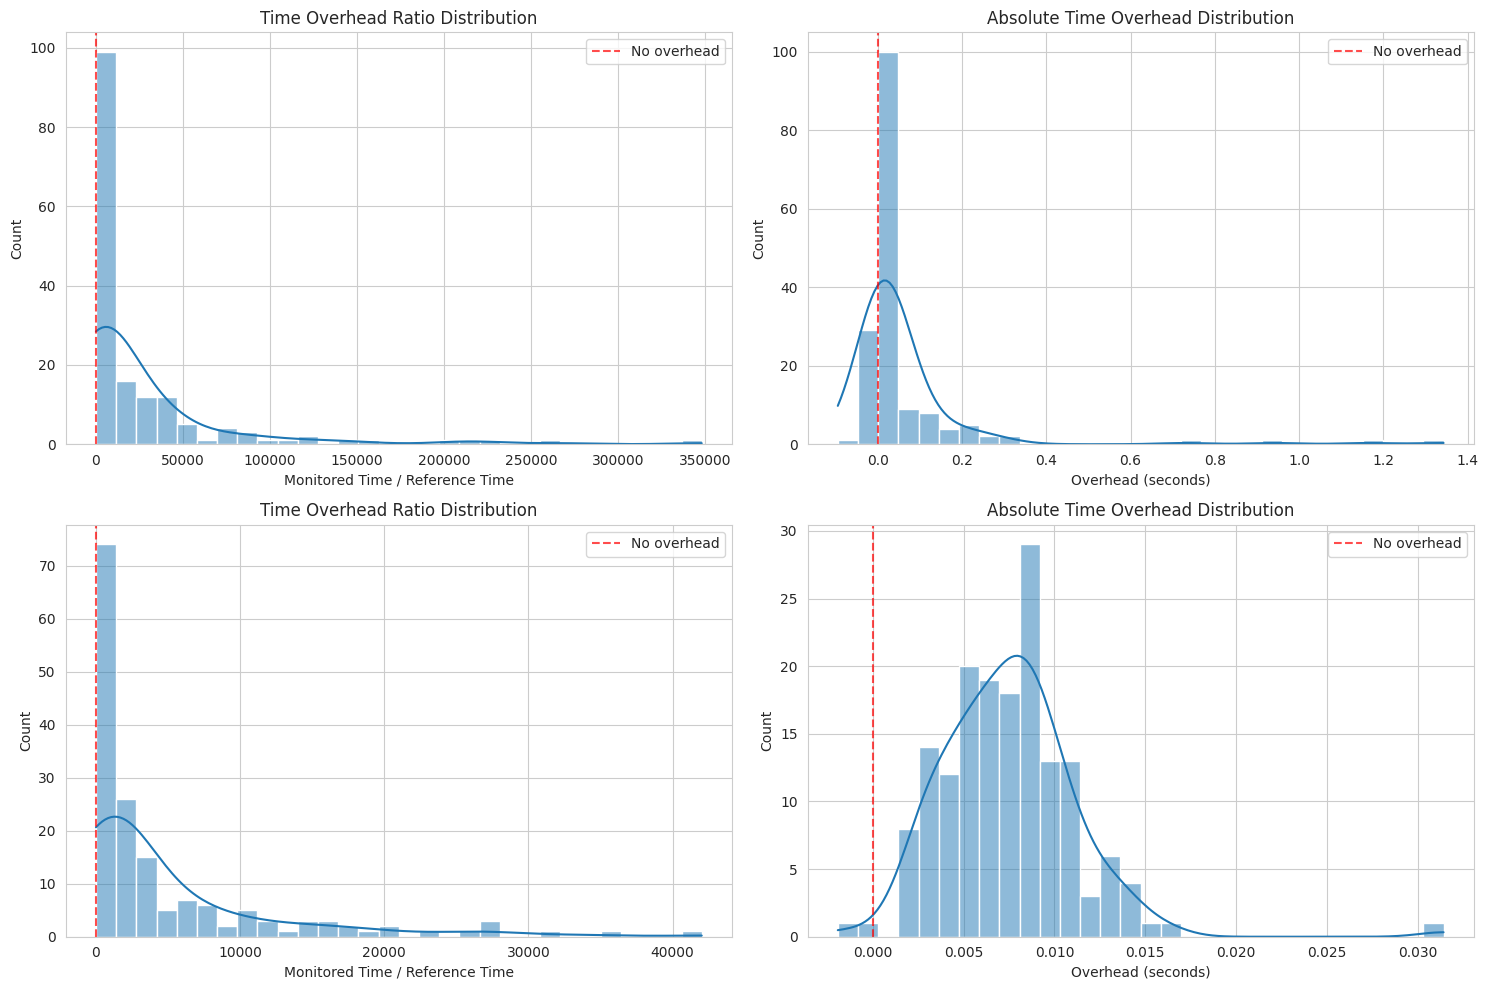

In [6]:
# Plot 3: Performance Overhead Analysis
plt.figure(figsize=(15, 10))

# Calculate overhead for successful runs
pivot_time = df.pivot(index='problem_index', columns='version', values='problem_time')
pivot_time = pivot_time.dropna()
pivot_time['overhead_ratio_line'] = pivot_time['monitored_line'] / pivot_time['reference']
pivot_time['overhead_absolute_line'] = pivot_time['monitored_line'] - pivot_time['reference']
pivot_time['overhead_ratio_function'] = pivot_time['monitored_function'] / pivot_time['reference']
pivot_time['overhead_absolute_function'] = pivot_time['monitored_function'] - pivot_time['reference']

# Overhead ratio distribution
plt.subplot(2, 2, 1)
sns.histplot(pivot_time['overhead_ratio_line'], bins=30, kde=True)
plt.axvline(x=1, color='red', linestyle='--', alpha=0.7, label='No overhead')
plt.title('Time Overhead Ratio Distribution')
plt.xlabel('Monitored Time / Reference Time')
plt.legend()

# Absolute overhead
plt.subplot(2, 2, 2)
sns.histplot(pivot_time['overhead_absolute_line'], bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='No overhead')
plt.title('Absolute Time Overhead Distribution')
plt.xlabel('Overhead (seconds)')
plt.legend()

# Overhead ratio distribution
plt.subplot(2, 2, 3)
sns.histplot(pivot_time['overhead_ratio_function'], bins=30, kde=True)
plt.axvline(x=1, color='red', linestyle='--', alpha=0.7, label='No overhead')
plt.title('Time Overhead Ratio Distribution')
plt.xlabel('Monitored Time / Reference Time')
plt.legend()

# Absolute overhead
plt.subplot(2, 2, 4)
sns.histplot(pivot_time['overhead_absolute_function'], bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='No overhead')
plt.title('Absolute Time Overhead Distribution')
plt.xlabel('Overhead (seconds)')
plt.legend()
plt.tight_layout()
plt.show()


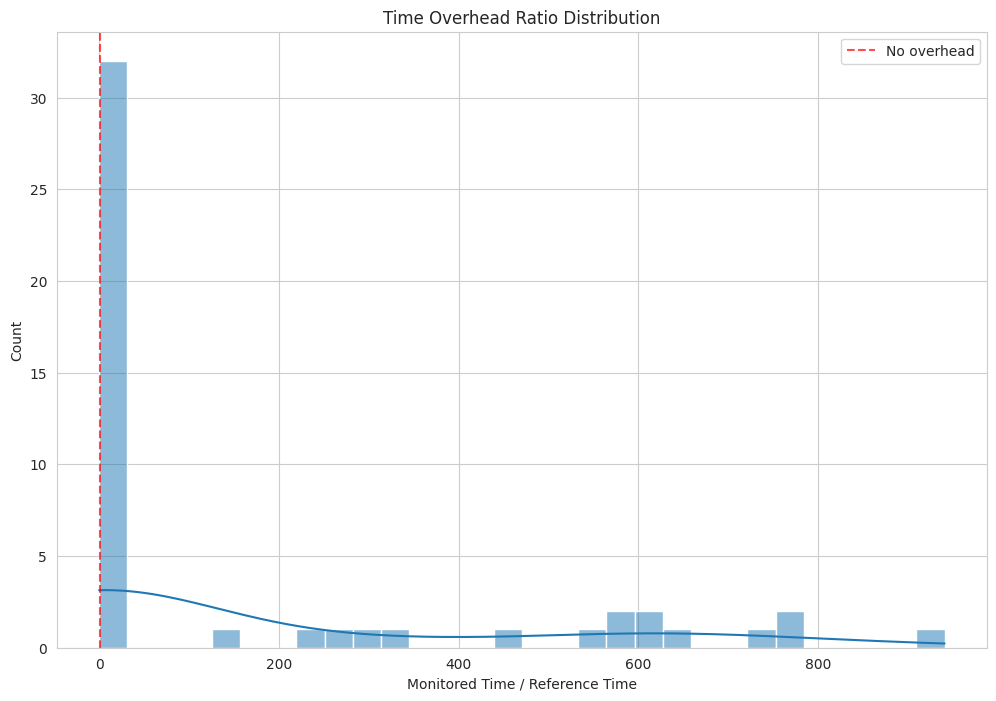

In [7]:
# Same as before, but remove outliers
# Calculate overhead for successful runs
pivot_time = df.pivot(index='problem_index', columns='version', values='problem_time')
pivot_time = pivot_time.dropna()
pivot_time['overhead_ratio'] = pivot_time['monitored_line'] / pivot_time['reference']

pivot_time = pivot_time[pivot_time['overhead_ratio'] < 1000]
sns.histplot(pivot_time['overhead_ratio'], bins=30, kde=True)
plt.axvline(x=1, color='red', linestyle='--', alpha=0.7, label='No overhead')
plt.title('Time Overhead Ratio Distribution')
plt.xlabel('Monitored Time / Reference Time')
plt.legend()
